In [97]:
import numpy as np
import scipy as sc
import skimage as img
from sklearn.feature_extraction.image import extract_patches_2d
from skimage import io
from skimage.color import rgb2lab
import seaborn as sns

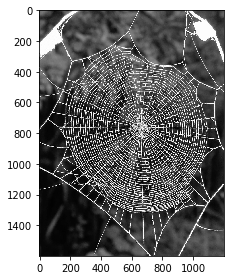

In [48]:
web_test = rgb2lab(io.imread("../data/test/demo_web.jpg"))
web_test_l = web_test[:,:,0]/100  # rescale L to be between 0 & 1

io.imshow(web_test_l)

In [49]:
web_test_l.std() # Basic RMS contrast is the stdev of the intensity

0.2757792788206016

In [50]:
web_test_patches = extract_patches_2d(web_test_l, (16,12))

In [51]:
web_test_patches.shape

(1884565, 16, 12)

In [3]:
import multiprocessing
from joblib import Parallel, delayed

num_cores = multiprocessing.cpu_count()

In [7]:
patch_stdevs = [web_test_patches[x,:,:].std() for x in range(web_test_patches.shape[0])]

That took _a while_! So let's see if parallelisation helps

In [5]:
def window_stdev(image, x):
    return image[x,:,:].std()

In [15]:
idxs = [x for x in range(web_test_patches.shape[0])]
# delayed returns a delayed version of the input func that then takes the arg of that func
patch_stdevs_mp = Parallel(n_jobs=num_cores)(delayed(window_stdev)(web_test_patches, x) for x in idxs)

Looks like a no, potentially the tasks are too small to be worth the overhead.

In [43]:
stickweb = rgb2lab(io.imread("../data/test/demo_stickweb.jpg"))[:,:,0]
stickweb_patches = extract_patches_2d(stickweb, (int(stickweb.shape[0]/250), int(stickweb.shape[1]/250)), max_patches=100000)
stickweb_patches.shape

(100000, 8, 11)

In [25]:
sw_patch_stdevs = [stickweb_patches[x,:,:].std() for x in range(stickweb_patches.shape[0])]

In [26]:
idxs = [x for x in range(stickweb_patches.shape[0])]
sw_patch_stdevs_mp = Parallel(n_jobs=num_cores)(delayed(window_stdev)(stickweb_patches, x) for x in idxs)

In [27]:
print(f"listcomp: mean={np.mean(sw_patch_stdevs)}, stdev={np.std(sw_patch_stdevs)}")
print(f"parallel: mean={np.mean(sw_patch_stdevs_mp)}, stdev={np.std(sw_patch_stdevs_mp)}")

listcomp: mean=2.48370730748969, stdev=4.5268991602151045
parallel: mean=2.48370730748969, stdev=4.5268991602151045


**Time to quickly test how patch count affects accuracy**

In [60]:
from ipywidgets import IntProgress, HBox
from IPython.display import display

progress = IntProgress(min=0, max=7, description='1', bar_style='')
display(progress)

stds_out = []

for x in range(8):
    stickweb_patches = extract_patches_2d(stickweb, (int(stickweb.shape[0]/250), int(stickweb.shape[1]/250)), max_patches=10**x)
    sw_patch_stdevs = [stickweb_patches[x,:,:].std() for x in range(stickweb_patches.shape[0])]
    stds_out.append(np.std(sw_patch_stdevs))
    progress.value += 1
    progress.description=str(10**(x+1))
progress.description = "Done!"
progress.bar_style = "success"

IntProgress(value=0, description='1', max=7)

In [61]:
stds_out

[0.0,
 2.5462430435081904,
 4.591655737668529,
 4.729114041375824,
 4.546889671343189,
 4.586014300639908,
 4.550106548749674,
 4.544437103078166]

At a patch size of 4x5, std window contrast normalises at about 10^5 samples
```
[0.0,
 2.5462430435081904,
 4.591655737668529,
 4.729114041375824,
 4.546889671343189,
 4.586014300639908,
 4.550106548749674,
 4.544437103078166]
```

At a patch size of 8x11, std window contrast also normalises at about 10^5 samples
```
[0.0,
 7.216792568308726,
 6.811162511008011,
 6.220233381676522,
 6.194552780300929,
 6.130705489472546,
 6.1284531706793555,
 6.114558483714619]
```

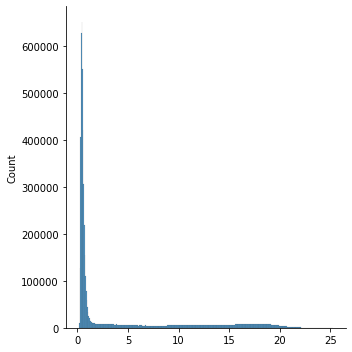

In [56]:
sns.displot(sw_patch_stdevs)

Let's test that for a lower contrast image!

IntProgress(value=0, description='1', max=7)

[0.0, 0.08853852916822254, 0.08401564989567817, 0.09734991559481365, 0.09549259931303444, 0.09453609781998297, 0.0947487612612457, 0.09471389178313179]


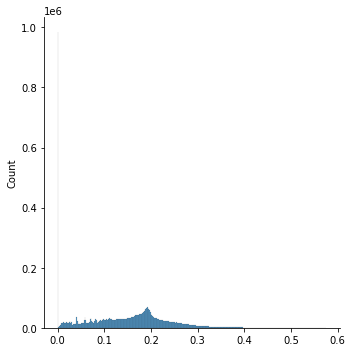

In [62]:
from ipywidgets import IntProgress, HBox
from IPython.display import display

stickweb_blur = rgb2lab(io.imread("../data/test/demo_stickweb_blurred.jpg"))[:,:,0]

progress = IntProgress(min=0, max=7, description='1', bar_style='')
display(progress)

stds_out = []

for x in range(8):
    stickweb_blur_patches = extract_patches_2d(stickweb_blur, (int(stickweb_blur.shape[0]/250), int(stickweb_blur.shape[1]/250)), max_patches=10**x)
    sw_blur_patch_stdevs = [stickweb_blur_patches[x,:,:].std() for x in range(stickweb_blur_patches.shape[0])]
    stds_out.append(np.std(sw_blur_patch_stdevs))
    progress.value += 1
    progress.description=str(10**(x+1))
progress.description = "Done!"
progress.bar_style = "success"

print(stds_out)

sns.displot(sw_blur_patch_stdevs)

---

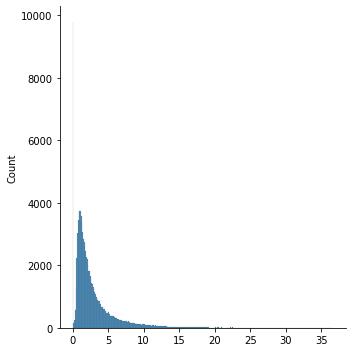

In [65]:
daylightweb = rgb2lab(io.imread("../data/test/daytime.jpg"))[:,:,0]
daylightweb_patches = extract_patches_2d(daylightweb, (int(daylightweb.shape[0]/250), int(daylightweb.shape[1]/250)), max_patches=100000)
daylightweb_patches.shape
daylightweb_patch_stdevs = [daylightweb_patches[x,:,:].std() for x in range(daylightweb_patches.shape[0])]
sns.displot(daylightweb_patch_stdevs)

/home/francis/Venvs/webmet/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

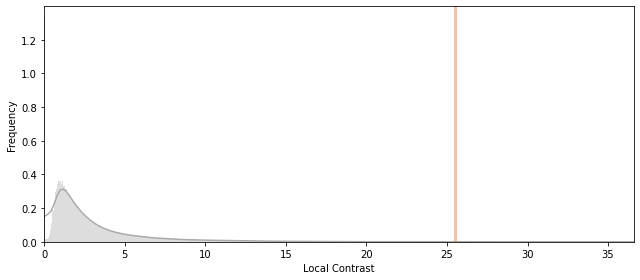

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9,4))
sns.distplot(daylightweb_patch_stdevs, hist=True,bins=500, kde=True, color="#aaaaaa", axlabel="Local Contrast", ax=ax)


ax.set_xlim(0,max(daylightweb_patch_stdevs))
ax.axvline(daylightweb.std(), color="#FF7F50", lw=3, alpha=0.5)
# ax.text(x=daylightweb.std()-10, y=0.069, s='Median', alpha=1, color='#FF7F50')

ax.set_ylabel("Frequency")

fig.tight_layout()
plt.plot()

# plt.savefig('../../../LaTeX/Presentations/SpiderWeb_QMEESymp/Images/meshdist.pdf',dpi=300, bbox_inches='tight')

/home/francis/Venvs/webmet/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

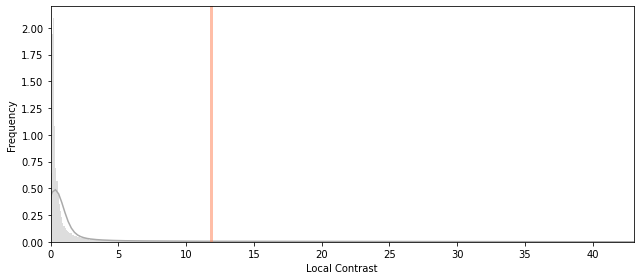

In [75]:
nighttimeweb = rgb2lab(io.imread("../data/test/nighttime.jpg"))[:,:,0]
nighttimeweb_patches = extract_patches_2d(nighttimeweb, (int(nighttimeweb.shape[0]/250), int(nighttimeweb.shape[1]/250)), max_patches=100000)
nighttimeweb_patches.shape
nighttimeweb_patch_stdevs = [nighttimeweb_patches[x,:,:].std() for x in range(nighttimeweb_patches.shape[0])]
# sns.displot(nighttimeweb_patch_stdevs)

fig, ax = plt.subplots(figsize=(9,4))
sns.distplot(nighttimeweb_patch_stdevs, hist=True,bins=500, kde=True, color="#aaaaaa", axlabel="Local Contrast", ax=ax)


ax.set_xlim(0,max(nighttimeweb_patch_stdevs))
ax.axvline(nighttimeweb.std(), color="#FF7F50", lw=3, alpha=0.5)
# ax.text(x=nighttimeweb_patch_stdevs.std()-10, y=0.069, s='Median', alpha=1, color='#FF7F50')

ax.set_ylabel("Frequency")

fig.tight_layout()
plt.plot()


In [83]:
import os, sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from webmet.digitise import digitise_web
hough_params = {
    "hough_thresh": 10,#10
    "hough_len": 10,#4
    "hough_gap": 8}#12
workingkernel_dict, intermediates = digitise_web("../data/test/daytime.jpg", **hough_params, return_intermediates=True)

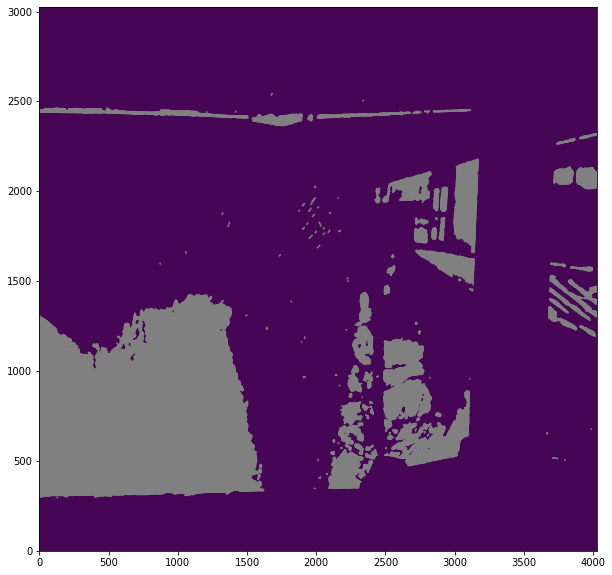

In [84]:
from webmet.merge import WebKernel, WebLine, load_kernel, multi_find_centroid, legacy_plot_kernel, plot_kernel
workingkernel = WebKernel(workingkernel_dict)
plot_kernel(workingkernel)

## Zero-centred FFT approach

In [108]:
stickweb_fft = np.fft.fft2(stickweb)
stickweb_fft_zs = np.fft.fftshift(stickweb_fft)
stickweb_fft_zs = np.log(np.abs(stickweb_fft_zs))

In [109]:
stickweb_fft_zs.dtype

dtype('float64')

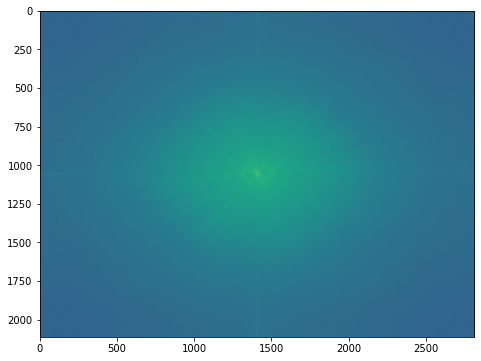

In [110]:
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(stickweb_fft_zs)

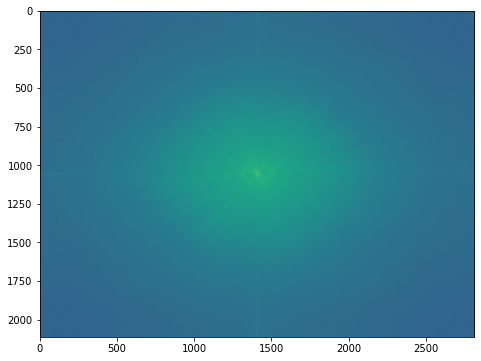

In [111]:
stickweb_blur_fft = np.fft.fft2(stickweb_blur)
stickweb_blur_fft_zs = np.fft.fftshift(stickweb_blur_fft)
stickweb_blur_fft_zs = np.log(np.abs(stickweb_blur_fft_zs))

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(stickweb_fft_zs)

In [116]:
print(f"{stickweb_blur_fft_zs.min()} - {stickweb_blur_fft_zs.max()}")

-2.411391729944763 - 19.58479442110752


In [115]:
print(f"{stickweb_fft_zs.min()} - {stickweb_fft_zs.max()}")

-0.18174495489063303 - 19.555297369729036


In [208]:
def get_zs_sharpness(image, plotit = False, verbose=False):
    """
    Get sharpness via the zero-shifted 2D FFT method
    De & Masilamani 2013
    """
    image_fft = np.fft.fft2(image)
    image_fft_zs = np.fft.fftshift(image_fft)
    abs_image_fft_zs = abs(image_fft_zs)
    maxval = abs_image_fft_zs.max()
    th = image_fft > maxval/1000
    th_count = np.count_nonzero(th)
    iqm = th_count / (image.shape[0] * image.shape[1])
    if plotit:
        image_fft_zs = np.log(np.abs(image_fft_zs))
        fig, ax = plt.subplots(2, figsize=(24,16))
#         ax[0].imshow(image_fft_zs) # Could also plot th here!
#         ax[0].set_title("0-Shifted FFT")
        ax[0].imshow(image, cmap="gray") # Could also plot th here!
        ax[0].set_title("Original")
        ax[1].imshow(th) # Could also plot th here!
        ax[1].set_title("0.1% High Pass")
        plt.tight_layout()
        plt.show()
        
    if verbose:
        print(f"{image_fft_zs.min()} - {image_fft_zs.max()}")
    return iqm

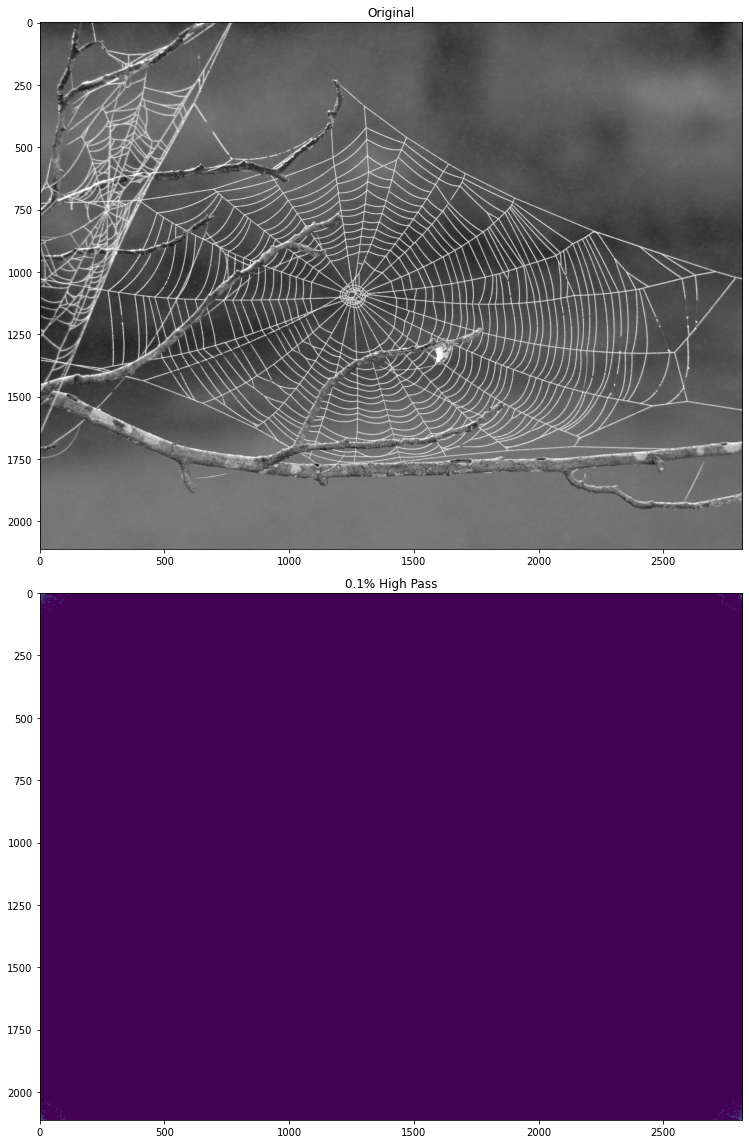

-0.18174495489063303 - 19.555297369729036


0.00012492870824724517

In [209]:
get_zs_sharpness(stickweb, True, True)

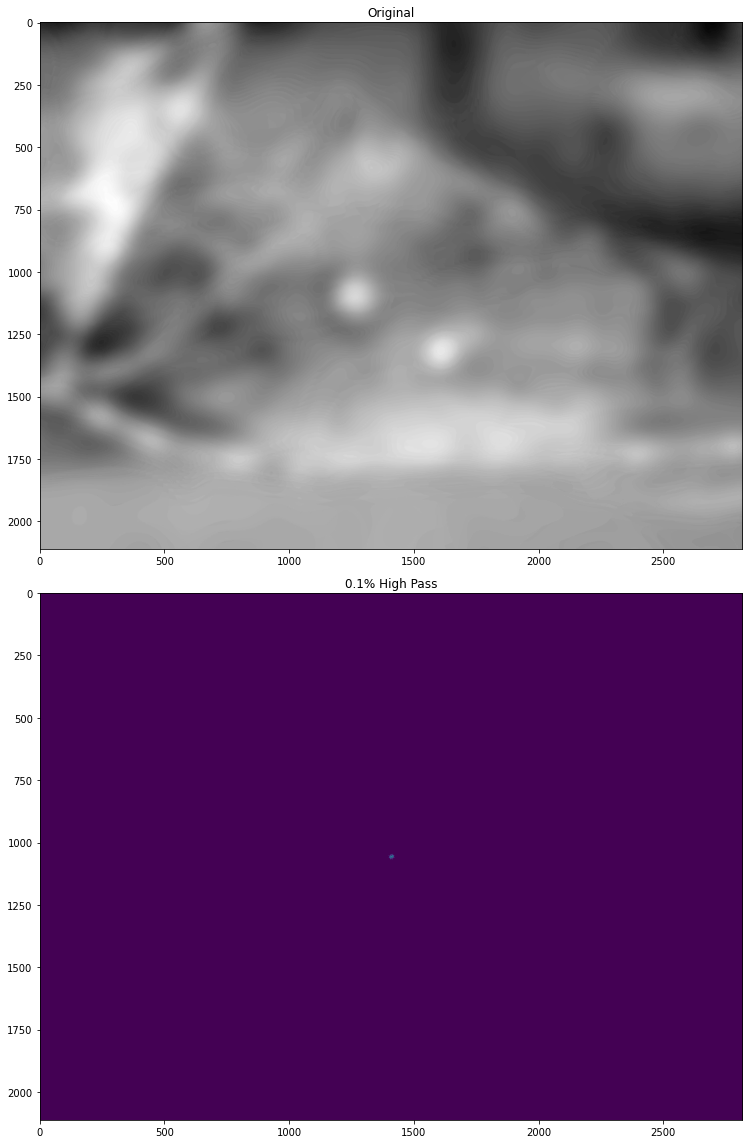

-2.411391729944763 - 19.58479442110752


1.2946851325757576e-05

In [202]:
get_zs_sharpness(stickweb_blur, True, True)

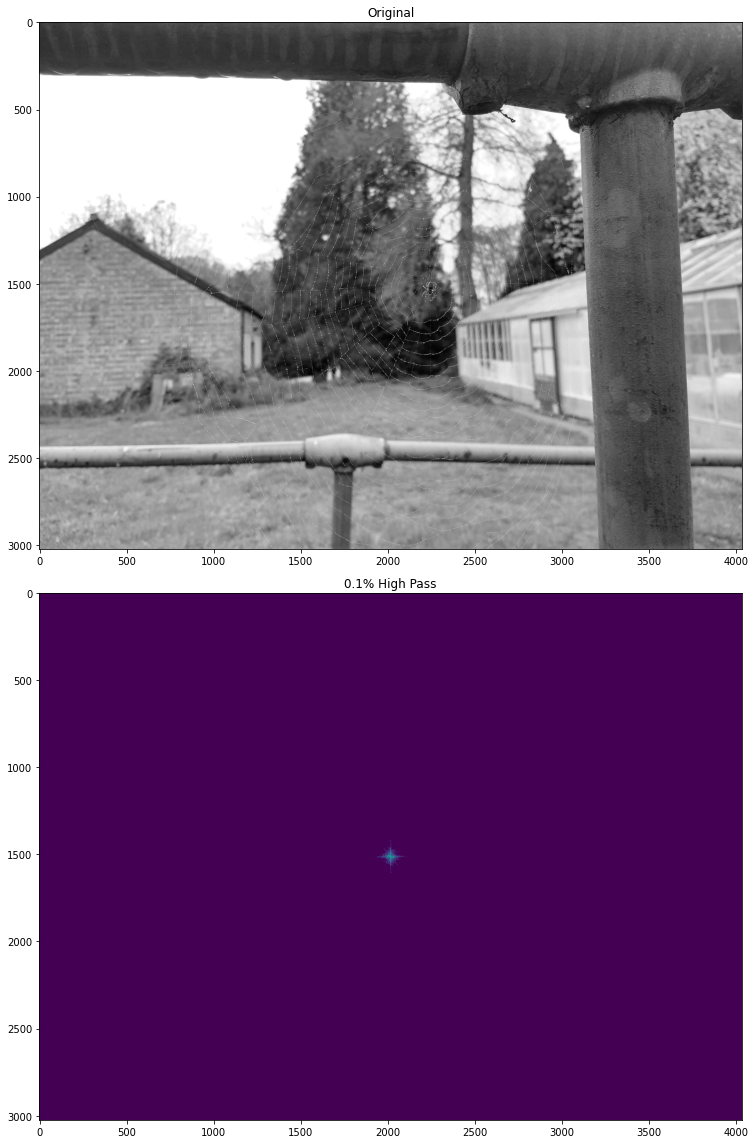

-1.0083564155556455 - 20.298377098803748


0.00011047532438901486

In [203]:
get_zs_sharpness(daylightweb, True, True)

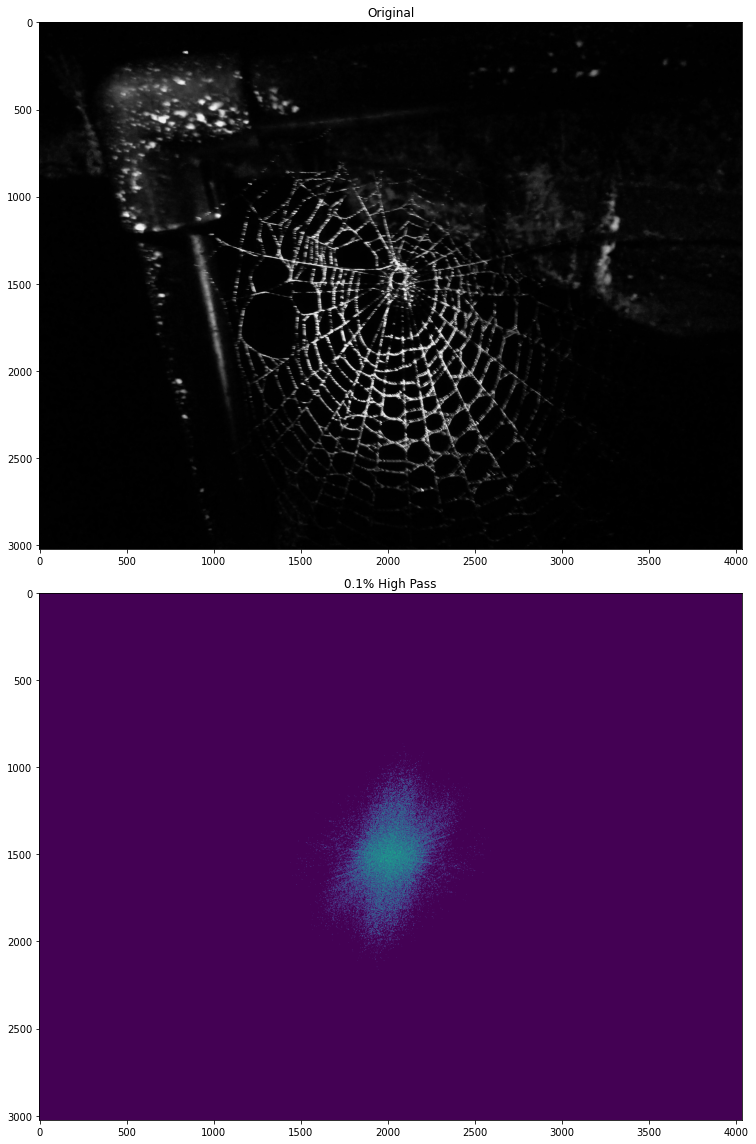

-0.6225873802291636 - 17.848212846532565


0.006890067948475687

In [204]:
get_zs_sharpness(nighttimeweb, True, True)

## Rolling window zs_sharpness

In [210]:
sw_patch_sharps = [get_zs_sharpness(stickweb_patches[x,:,:]) for x in range(stickweb_patches.shape[0])]

/home/francis/Venvs/webmet/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

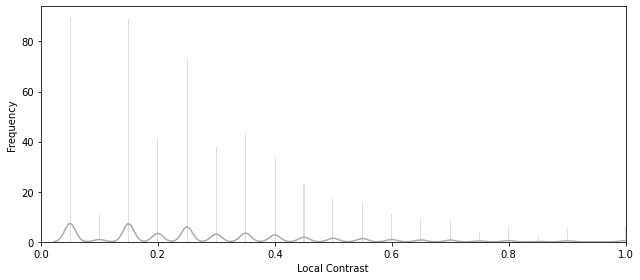

In [214]:
fig, ax = plt.subplots(figsize=(9,4))
sns.distplot(sw_patch_sharps, hist=True,bins=500, kde=True, color="#aaaaaa", axlabel="Local Sharpness", ax=ax)


ax.set_xlim(0,max(sw_patch_sharps))
# ax.axvline(nighttimeweb.std(), color="#FF7F50", lw=3, alpha=0.5)
# ax.text(x=nighttimeweb_patch_stdevs.std()-10, y=0.069, s='Median', alpha=1, color='#FF7F50')

ax.set_ylabel("Frequency")

fig.tight_layout()
plt.plot()

In [211]:
def parr_get_zs_sharpness(image, x):
    return get_zs_sharpness(image[x,:,:])

In [212]:
idxs = [x for x in range(stickweb_patches.shape[0])]
sw_patch_sharps_mp = Parallel(n_jobs=num_cores)(delayed(parr_get_zs_sharpness)(stickweb_patches, x) for x in idxs)

/home/francis/Venvs/webmet/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

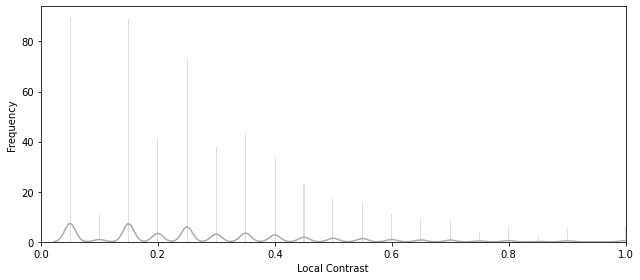

In [215]:
fig, ax = plt.subplots(figsize=(9,4))
sns.distplot(sw_patch_sharps_mp, hist=True,bins=500, kde=True, color="#aaaaaa", axlabel="Local Sharpness", ax=ax)


ax.set_xlim(0,max(sw_patch_sharps_mp))
# ax.axvline(nighttimeweb.std(), color="#FF7F50", lw=3, alpha=0.5)
# ax.text(x=nighttimeweb_patch_stdevs.std()-10, y=0.069, s='Median', alpha=1, color='#FF7F50')

ax.set_ylabel("Frequency")

fig.tight_layout()
plt.plot()

In [219]:
progress = IntProgress(min=0, max=7, description='1', bar_style='')
display(progress)

sharps_out = []

for x in range(8):
    stickweb_patches = extract_patches_2d(stickweb, (int(stickweb.shape[0]/250), int(stickweb.shape[1]/250)), max_patches=10**x)
    idxs = [x for x in range(stickweb_patches.shape[0])]
    sw_patch_sharps_looped = Parallel(n_jobs=num_cores)(delayed(parr_get_zs_sharpness)(stickweb_patches, x) for x in idxs)
#     sw_patch_stdevs = [stickweb_patches[x,:,:].std() for x in range(stickweb_patches.shape[0])]
    sharps_out.append(np.median(sw_patch_sharps_looped))
    progress.value += 1
    progress.description=str(10**(x+1))
progress.description = "Done!"
progress.bar_style = "success"

IntProgress(value=0, description='1', max=7)

In [220]:
sharps_out

[0.32954545454545453,
 0.1477272727272727,
 0.125,
 0.10227272727272728,
 0.10227272727272728,
 0.10227272727272728,
 0.10227272727272728,
 0.10227272727272728]

Looks like it levels out around 10^4 patches.

## Rolling window zs_sharpness between day & night

(100000, 12, 16)


/home/francis/Venvs/webmet/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

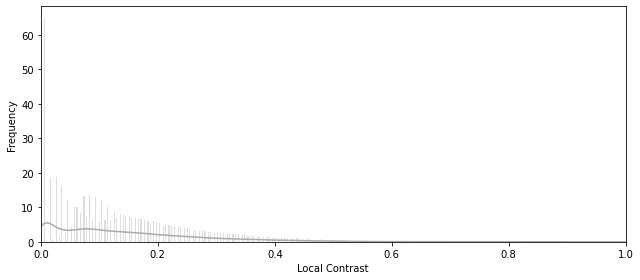

In [222]:
print(daylightweb_patches.shape)
idxs = [x for x in range(daylightweb_patches.shape[0])]
daylight_patch_sharps = Parallel(n_jobs=num_cores)(delayed(parr_get_zs_sharpness)(daylightweb_patches, x) for x in idxs)

fig, ax = plt.subplots(figsize=(9,4))
sns.distplot(daylight_patch_sharps, hist=True,bins=500, kde=True, color="#aaaaaa", axlabel="Local Sharpness", ax=ax)
ax.set_xlim(0,max(daylight_patch_sharps))
ax.set_ylabel("Frequency")

fig.tight_layout()
plt.plot()

(100000, 12, 16)


/home/francis/Venvs/webmet/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

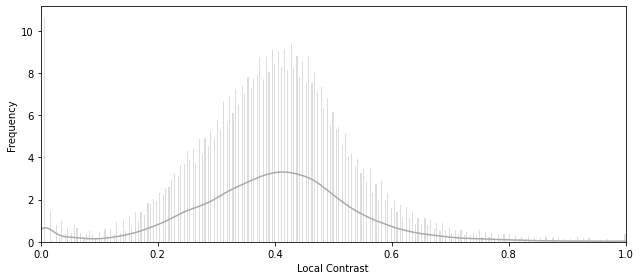

In [223]:
print(nighttimeweb_patches.shape)
idxs = [x for x in range(nighttimeweb_patches.shape[0])]
nighttimeweb_patch_sharps = Parallel(n_jobs=num_cores)(delayed(parr_get_zs_sharpness)(nighttimeweb_patches, x) for x in idxs)

fig, ax = plt.subplots(figsize=(9,4))
sns.distplot(nighttimeweb_patch_sharps, hist=True,bins=500, kde=True, color="#aaaaaa", axlabel="Local Sharpness", ax=ax)
ax.set_xlim(0,max(nighttimeweb_patch_sharps))
ax.set_ylabel("Frequency")

fig.tight_layout()
plt.plot()